In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.segmentation import slic
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
import networkx as nx
import json
import shap

/opt/homebrew/Caskroom/miniforge/base/envs/PyTc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X, y = shap.datasets.imagenet50()
# Getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
print("Number of ImageNet classes:", len(class_names))
# print("Class names:", class_names)

Number of ImageNet classes: 1000


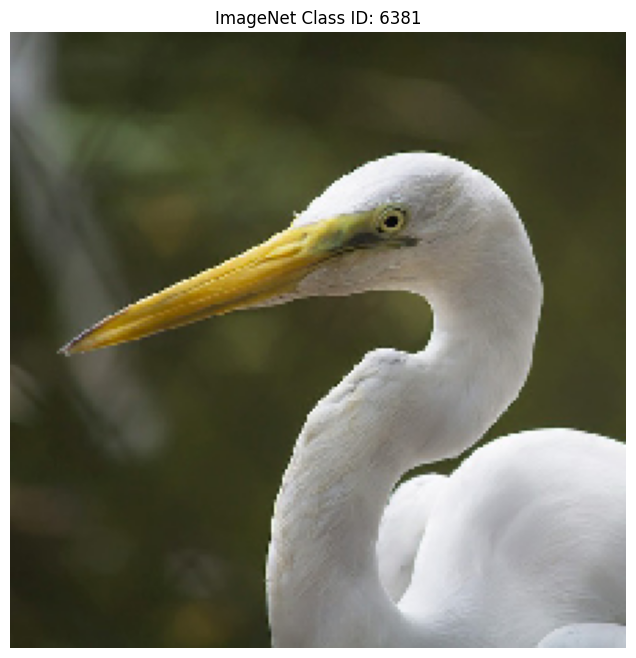

Image shape: (224, 224, 3)
Value range: Min=0.0, Max=255.0


In [20]:
# Select an image to display (index 0 in this case)
img = X[1]

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img.astype('uint8'))
plt.axis('off')
plt.title(f'ImageNet Class ID: {int(y[0])}')
plt.show()

# Print image shape information
print(f"Image shape: {img.shape}")
print(f"Value range: Min={img.min()}, Max={img.max()}")

In [21]:
if img.shape[-1] == 4:
    img = img[..., :3]  # 如果是RGBA，去掉透明度通道

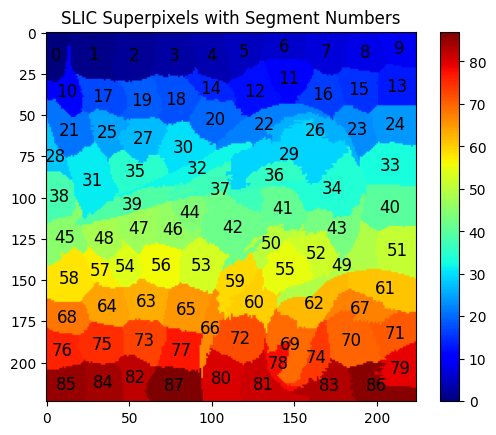

In [22]:
# 2. 超像素分割
n_segments = 100  # 超像素数量可以调
segments = slic(img, n_segments=n_segments, compactness=10, start_label=0)

# Plot the superpixels with their corresponding segment numbers
plt.imshow(segments, cmap='jet')
plt.title('SLIC Superpixels with Segment Numbers')
plt.colorbar()

# Annotate each segment with its number
for seg_val in np.unique(segments):
    mask = (segments == seg_val)
    coords = np.column_stack(np.where(mask))
    if len(coords) > 0:
        centroid_y, centroid_x = np.mean(coords, axis=0)
        plt.text(centroid_x, centroid_y, str(seg_val), color='black', fontsize=12, ha='center', va='center')

plt.show()

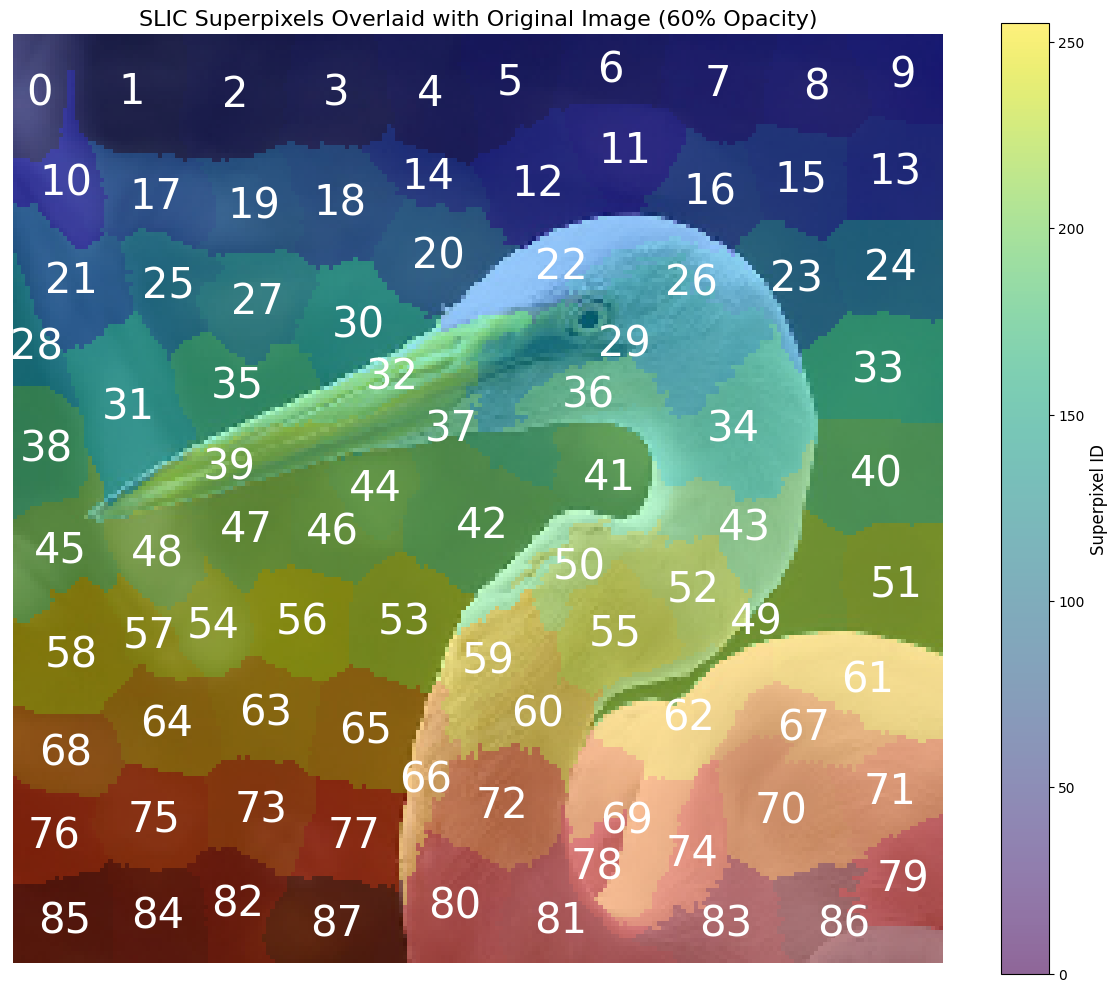

In [23]:
# Create a visualization with the original image overlaid on the segmentation map
plt.figure(figsize=(12, 10))

# First show the segmentation map (superpixels)
plt.imshow(segments, cmap='jet')

# Overlay the original image with transparency
plt.imshow(img.astype('uint8'), alpha=0.6)  # Set transparency to 0.6

# Add a title
plt.title('SLIC Superpixels Overlaid with Original Image (60% Opacity)', fontsize=16)

# Add a colorbar for the segmentation
cbar = plt.colorbar()
cbar.set_label('Superpixel ID', fontsize=12)
# Annotate each segment with its number
for seg_val in np.unique(segments):
    mask = (segments == seg_val)
    coords = np.column_stack(np.where(mask))
    if len(coords) > 0:
        centroid_y, centroid_x = np.mean(coords, axis=0)
        plt.text(centroid_x, centroid_y, str(seg_val), color='white', fontsize=30, ha='center', va='center')
plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show()

In [24]:
# 3. 每个超像素提取特征（均值颜色+简单纹理）
features = []
for seg_val in np.unique(segments):
    mask = (segments == seg_val)
    
    # 1. 颜色特征
    mean_color = np.mean(img[mask], axis=0)  # RGB均值 (3维)
    std_color = np.std(img[mask], axis=0)    # RGB标准差 (3维)
    
    # 2. 形状和空间特征
    coords = np.column_stack(np.where(mask))
    
    if len(coords) > 0:
        # 位置信息 - 质心 (2维)
        centroid_y, centroid_x = np.mean(coords, axis=0)
        
        # 面积 (1维)
        area = len(coords)
        
        # 边界框尺寸 (2维)
        minr, minc = coords.min(axis=0)
        maxr, maxc = coords.max(axis=0)
        height = maxr - minr + 1
        width = maxc - minc + 1
        
        # 3. 纹理特征
        gray = color.rgb2gray(img)
        region = gray[minr:maxr+1, minc:maxc+1]
        region_masked = np.zeros_like(region)
        local_mask = mask[minr:maxr+1, minc:maxc+1]
        
        if local_mask.size > 0 and np.any(local_mask):
            region_masked[local_mask] = region[local_mask]
            # GLCM特征 (4维)
            try:
                glcm = graycomatrix((region_masked * 255).astype(np.uint8), 
                                   distances=[1], angles=[0], 
                                   levels=256, symmetric=True, normed=True)
                contrast = graycoprops(glcm, 'contrast')[0, 0]
                dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
                homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
                energy = graycoprops(glcm, 'energy')[0, 0]
                # 相关性可能会出现NaN，所以需要处理这种情况
                try:
                    correlation = graycoprops(glcm, 'correlation')[0, 0]
                    if np.isnan(correlation):
                        correlation = 0.0
                except:
                    correlation = 0.0
            except:
                # 如果GLCM计算失败，使用默认值
                contrast = dissimilarity = homogeneity = energy = correlation = 0.0
                
            # 像素值统计 (2维)
            if np.any(local_mask):
                pixel_mean = np.mean(region[local_mask])
                pixel_std = np.std(region[local_mask])
            else:
                pixel_mean = pixel_std = 0.0
        else:
            # 默认纹理特征值
            contrast = dissimilarity = homogeneity = energy = correlation = 0.0
            pixel_mean = pixel_std = 0.0
            
        # 汇总所有特征，确保维度一致
        feature_vector = np.hstack([
            mean_color,                  # RGB均值 (3维)
            std_color,                   # RGB标准差 (3维)
            [centroid_y, centroid_x],    # 质心坐标 (2维)
            [area],                      # 面积 (1维)
            [height, width],             # 边界框尺寸 (2维)
            [contrast, dissimilarity, homogeneity, energy, correlation],  # 纹理特征 (5维)
            [pixel_mean, pixel_std]      # 像素统计 (2维)
        ])
        # 检查确保没有NaN值
        feature_vector = np.nan_to_num(feature_vector, nan=0.0)
    else:
        # 如果没有足够的像素，填充默认值
        # 总共18维特征
        feature_vector = np.zeros(18)
    
    features.append(feature_vector)

features = np.array(features).T

In [25]:
labels = [i for i in range(features.shape[1])]

# 标准化特征
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 4. 因果推断（PC算法）
# PC算法要求输入的是变量在不同样本下的取值，这里我们反过来直接当特征点彼此独立的小样本来建图
# 这里只是示意用，实际要考虑更多数据的话需要采样更多patch
causal_graph = pc(features_scaled, independence_test_method='fisherz', alpha=0.2)

print(causal_graph.G)

/opt/homebrew/Caskroom/miniforge/base/envs/PyTc/lib/python3.12/site-packages/causallearn/search/ConstraintBased/PC.py:36: UserWarning: The number of features is much larger than the sample size!
  warnings.warn("The number of features is much larger than the sample size!")
  0%|          | 0/88 [00:00<?, ?it/s]

Depth=2, working on node 87: 100%|██████████| 88/88 [00:00<00:00, 1239.63it/s]


Graph Nodes:
X1;X2;X3;X4;X5;X6;X7;X8;X9;X10;X11;X12;X13;X14;X15;X16;X17;X18;X19;X20;X21;X22;X23;X24;X25;X26;X27;X28;X29;X30;X31;X32;X33;X34;X35;X36;X37;X38;X39;X40;X41;X42;X43;X44;X45;X46;X47;X48;X49;X50;X51;X52;X53;X54;X55;X56;X57;X58;X59;X60;X61;X62;X63;X64;X65;X66;X67;X68;X69;X70;X71;X72;X73;X74;X75;X76;X77;X78;X79;X80;X81;X82;X83;X84;X85;X86;X87;X88

Graph Edges:
1. X2 --- X32
2. X30 --> X3
3. X32 --> X3
4. X4 --- X6
5. X5 --- X13
6. X5 --- X19
7. X15 --> X7
8. X24 --> X7
9. X12 --> X8
10. X41 --> X8
11. X9 --- X14
12. X9 --- X16
13. X10 --- X24
14. X11 --> X20
15. X14 --- X16
16. X14 --- X25
17. X15 --- X45
18. X18 --- X26
19. X26 --> X20
20. X28 --> X20
21. X22 --- X59
22. X23 --- X27
23. X23 --> X33
24. X23 --> X63
25. X29 --- X45
26. X29 --> X49
27. X30 --- X35
28. X30 --- X50
29. X31 --> X36
30. X31 --- X42
31. X44 --> X33
32. X34 --- X41
33. X34 --- X56
34. X35 --- X50
35. X35 --- X62
36. X54 --> X36
37. X37 --- X67
38. X38 --- X40
39. X46 --> X39
40. X54 --> X39
41. X56 --> 

In [9]:
# Build a NetworkX graph from the adjacency matrix
def build_nx_graph(causal_graph, labels):
    import networkx as nx
    G = nx.DiGraph()
    num_nodes = len(labels)
    G.add_nodes_from(range(num_nodes))
    # Add edges based on causal graph structure
    for i in range(num_nodes):
        for j in range(num_nodes):
            edge_type = causal_graph.G.graph[i][j]
            if edge_type == 1: # Directed edge from i to j
                G.add_edge(j, i)
            elif edge_type == -1: # Directed edge from j to i
                G.add_edge(i, j)
            elif edge_type == 2: # Undirected edge
                G.add_edge(i, j)
                G.add_edge(j, i)
    # Relabel nodes with variable names
    mapping = {i: label for i, label in enumerate(labels)}
    G = nx.relabel_nodes(G, mapping)
    return G

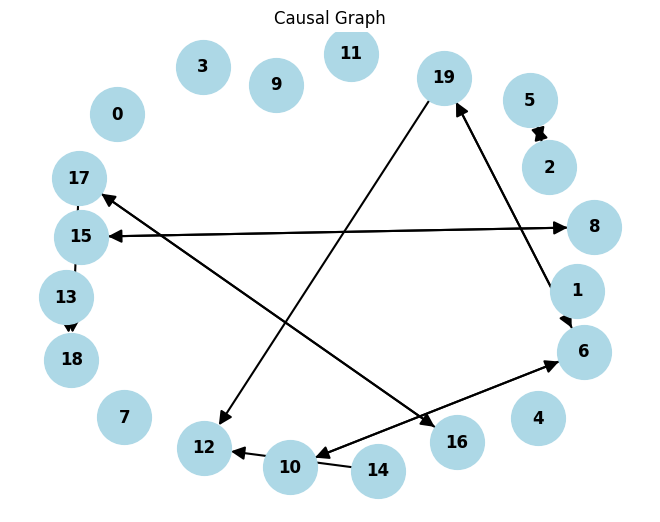

In [10]:
G = build_nx_graph(causal_graph, labels)

# Plot the causal graph
pos = nx.spring_layout(G, k=4.0)  # k parameter increases the spacing between nodes
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=1500,
    node_color='lightblue',
    arrowsize=20,
    font_size=12,
    font_weight='bold',
    arrows=True,
    width=1.5  # Increase edge width for better visibility
)
plt.title('Causal Graph')
plt.show()

In [11]:
import torch
import torch.nn as nn
import torchvision

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torchvision.models.mobilenet_v2(pretrained=True, progress=False)
model.to(device)
model.eval()

/opt/homebrew/Caskroom/miniforge/base/envs/PyTc/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/PyTc/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [13]:
# Prepare data transformation pipeline

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

In [14]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    return output

In [15]:
# Check that transformations work correctly
Xtr = transform(torch.Tensor(X))
out = predict(Xtr[1:3])
classes = torch.argmax(out, axis=1).cpu().numpy()
print(f"Classes: {classes}: {np.array(class_names)[classes]}")

Classes: [132 814]: ['American_egret' 'speedboat']


In [16]:
topk = 4
batch_size = 50
n_evals = 10000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    Xtr[1:2],
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

PartitionExplainer explainer: 2it [06:30, 390.26s/it]              


In [17]:
(shap_values.data.shape, shap_values.values.shape)

(torch.Size([1, 224, 224, 3]), (1, 224, 224, 3, 4))

In [18]:
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

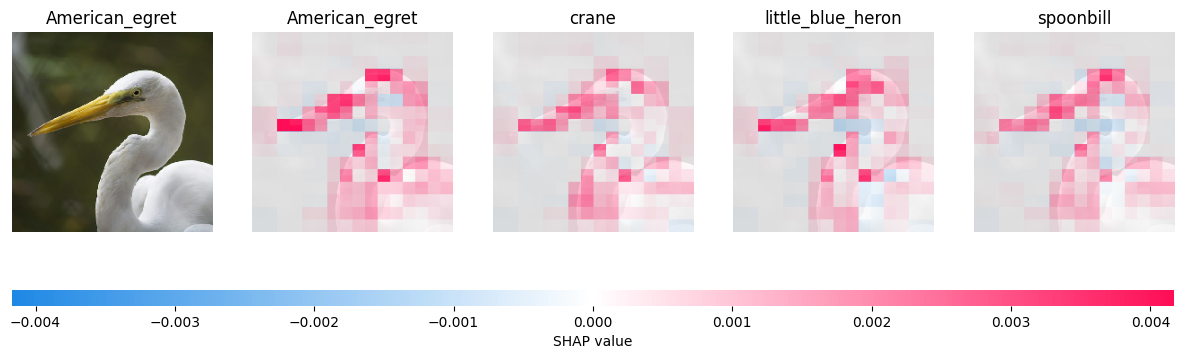

In [19]:
shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[class_names[132]],
)